40
4
40
4
40
4
Shear Modulus (mu): 76923076923.07692
Lame Modulus (_lambda): 115384615384.61539
Make sure you write dimesnions using writeDimensions(nx, ny)
2 0.1 40 4


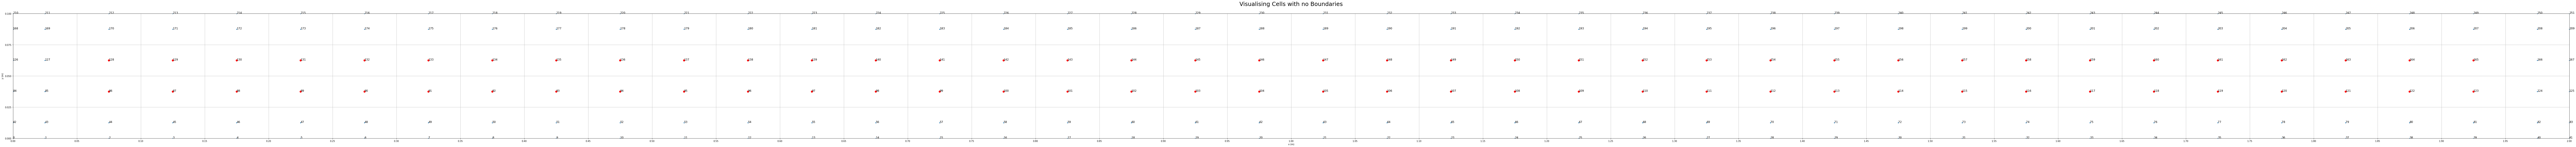

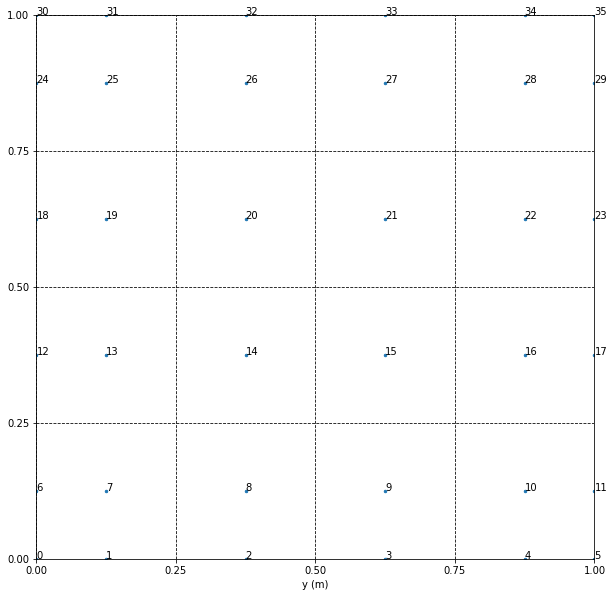

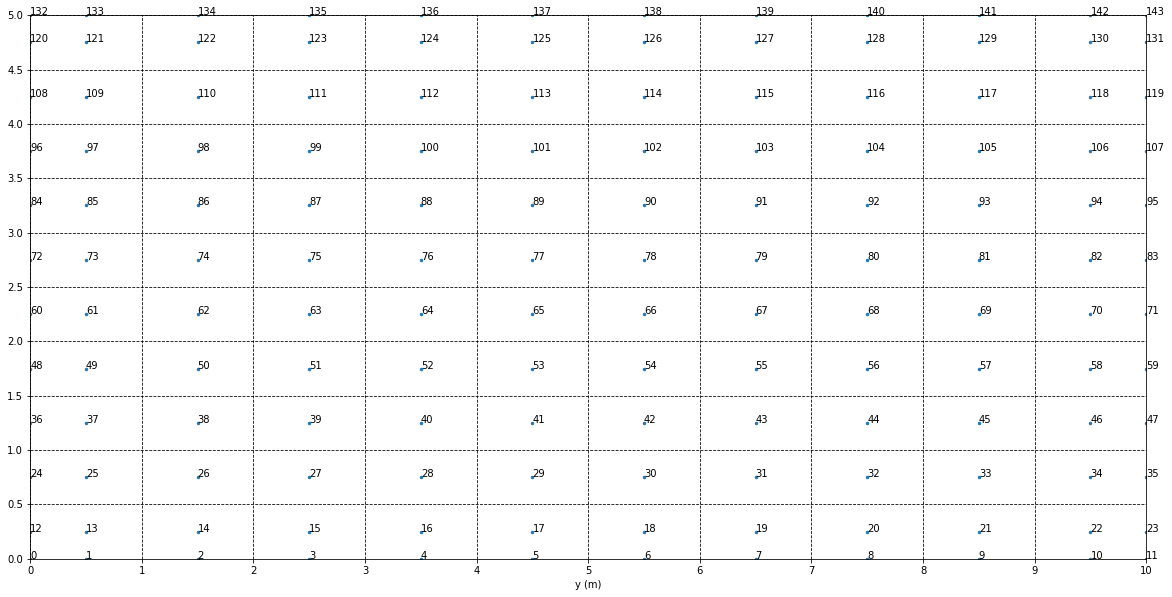

(144, 2)
Number of points in Mesh: 144
Number of dimensions: 2
Shear Modulus (mu): 76923076923.07692
Lame Modulus (_lambda): 115384615384.61539


In [1]:
from ipynb.fs.full.Background_Functions import *
from ipynb.fs.full._05_Fixed_Traction_BCs import *

## Solution Algorithm

---


Now that we've described and coded the $a$ matrix and $b$ matrix for: all points within the mesh, and both the x and y momentum equations. We now need to discuss how these matrices will be solved.


**Step 1:** Initialise Matrix

- We'll create both the A and b matrices for the x and y equations


**Step 2:** Solve Matrix

- We'll solve for a solution displacement field $(u , v)$. We know

$$
\begin{bmatrix} a \end{bmatrix}_x
\begin{bmatrix} u \end{bmatrix}
 = \begin{bmatrix} b \end{bmatrix}_x
$$

$$
\begin{bmatrix} a \end{bmatrix}_y
\begin{bmatrix} v \end{bmatrix}
 = \begin{bmatrix} b \end{bmatrix}_y
$$


However we also know that:

- $ \begin{bmatrix} b \end{bmatrix}\_x $ is a function of $v$

- $ \begin{bmatrix} b \end{bmatrix}\_y $ is a function of $u$

Perhaps now you can see a problem: when solve for $u$ and $v$ using our matrices, these fields may be different to the fields that are used in the b-terms?

So how do we solve this?

One thing we could do is pass the solution field back into the b-terms, create new b-matrices, and resolve for the displacement fields?

But again the solution field may still be different to the field used to create the b matrix.


$$
\begin{align*}
\begin{bmatrix} a \end{bmatrix}_x
\begin{bmatrix} u \end{bmatrix}
 = \begin{bmatrix} b(v) \end{bmatrix}_x  \rightarrow &   \space \space \space \space u  &\\
\begin{bmatrix} a \end{bmatrix}_y
\begin{bmatrix} v \end{bmatrix}
 = \begin{bmatrix} b(u) \end{bmatrix}_y  \rightarrow &  \space \space \space \space v &\\
 \space \space & \space \space \space \downarrow &\\
\begin{bmatrix} a \end{bmatrix}_x
\begin{bmatrix} u \end{bmatrix}
= & \begin{bmatrix} b(v) \end{bmatrix}_x \rightarrow &  u  \\
\begin{bmatrix} a \end{bmatrix}_y
\begin{bmatrix} v \end{bmatrix}
= & \begin{bmatrix} b(u) \end{bmatrix}_y \rightarrow &  v \\
\end{align*}
$$


So we need to set a _tolerance_ for how small the difference the solution displacement and the displacement used to generate the b matrix can be before we consider the solution to be solved?\*\*

Let's think of how this loop will be solved:


        while (!converged):

                # set previous displacement solutions
                U_previous = u
                v_previous = v

                # x equation
                create A matrix
                create b matrix using v_previous
                solve for u

                # y equation
                create A matrix
                create b matrix using U_previous
                solve for v

                find the maximum difference (residual) between u and U_previous
                find the maximum difference (residual) between v and v_previous

                if (both maximum differences are less that the preset tolerance):
                        converged = True
                else
                        converged = False


\*Explain how this method is implicit


The first step required in the convergence loop is to create the A matrix.


#### Create the A matrix

Previously we have created the A matrix for cell with no boundaries. This is as follows:


In [2]:
# x A matrix
A_x = A("x").createMatrix()

# y A matrix
A_y = A("y").createMatrix()


#### Fill in boundary values in A and b matrices


So far for each point and cell on boundaries we've created functions that take in A and b matrices and assign the a-terms and b-terms to these matrices. Now we need to write a function that loops through each point <code>k</code> in the mesh and assign the correct term.

For each point/cell we need to determine if the what type of BC is applied. <code>cell_corner_BCs</code> already looks up what BC is applied so we only need to write functions for the boundary cells and points:


For Cells:


In [3]:
def cell_boundary_selection(
    A_matrix, b_matrix, k, boundaries, xy, U_old, U_old_old, U_previous
):

    if BC_settings(boundaries[0]).traction:
        A_matrix, b_matrix = traction_cell_BCs(
            A_matrix, b_matrix, k, boundaries, xy, U_old, U_old_old, U_previous
        )

    elif BC_settings(boundaries[0]).fixed_displacement:
        A_matrix, b_matrix = displacement_cell_BCs(
            A_matrix, b_matrix, k, boundaries, xy, U_old, U_old_old, U_previous
        )

    return A_matrix, b_matrix


For Points:


In [4]:
def point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous):

    if BC_settings(boundaries[0]).traction:
        A_matrix, b_matrix = traction_point_BCs(
            A_matrix, b_matrix, k, boundaries, xy, U_previous
        )

    elif BC_settings(boundaries[0]).fixed_displacement:
        A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries, xy)

    return A_matrix, b_matrix


For we can loop through each point <code>k</code>, determine if it is a boundary point, cell or corner, and apply the BC terms. This function is long but it is simple once you go through it.

In [5]:
fac = 100000000

In [6]:
def boundary_conditions(A_matrix, b_matrix, U_previous, u_old, u_old_old, xy):
    for k in np.arange(0,(nx+2)*(ny+2)):   # j is the cell number


       #Bottom left corner coefficients        
        if cell_index().bottom_left_corner(k):  

            boundaries = ["b", "l"]
            
            A_matrix, b_matrix = cell_corner_BCs(A_matrix, b_matrix, k, boundaries, xy, U_previous, u_old, u_old_old)          

        #Bottom right corner coefficients            
        elif  cell_index().bottom_right_corner(k):
            boundaries = ["b", "r"]
            
            A_matrix, b_matrix = cell_corner_BCs(A_matrix, b_matrix, k, boundaries, xy, U_previous, u_old, u_old_old)

        #Top left corner coefficients            
        elif  cell_index().top_left_corner(k):
            boundaries = ["t", "l"]
        
            A_matrix, b_matrix = cell_corner_BCs(A_matrix, b_matrix, k, boundaries, xy, U_previous, u_old, u_old_old)

        #Top right corner coefficients            
        elif  cell_index().top_right_corner(k):  
            boundaries = ["t", "r"]
            
            A_matrix, b_matrix = cell_corner_BCs(A_matrix, b_matrix, k, boundaries, xy, U_previous, u_old, u_old_old)

        # Center Bottom Boundaries
        elif  cell_index().center_bottom(k):
            boundaries = ["b"]

            A_matrix, b_matrix = cell_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, u_old, u_old_old, U_previous)

        # Center Top Boundaries
        elif cell_index().center_top(k):
            boundaries = ["t"]

            A_matrix, b_matrix = cell_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, u_old, u_old_old, U_previous)

        # Center Left Boundaries
        elif  cell_index().center_left(k):
            boundaries = ["l"]

            A_matrix, b_matrix = cell_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, u_old, u_old_old, U_previous)

        # Center Right Boundaries
        elif  cell_index().center_right(k):
            boundaries = ["r"]

            A_matrix, b_matrix = cell_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, u_old, u_old_old, U_previous)

        #### Points on Boundary ####

        # Center Bottom
        elif boundary_point_index().center_bottom(k):
            boundaries = ["b"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)

        # Center Top
        elif boundary_point_index().center_top(k):
            boundaries = ["t"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)

            
        # Center Left
        elif boundary_point_index().center_left(k):
            boundaries = ["l"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)


        # Center Right
        elif boundary_point_index().center_right(k):
            boundaries = ["r"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)


        # Bottom Left: Bottom
        elif boundary_point_index().bottom_left_bottom(k):
            boundaries = ["b", "l"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)


        # Bottom Left: Left
        elif boundary_point_index().bottom_left_left(k):
            boundaries = ["l", "b"]
            
            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)

            
        # Bottom Right: Right
        elif boundary_point_index().bottom_right_right(k):
            boundaries = ["r", "b"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)

        # Bottom Right: Bottom
        elif boundary_point_index().bottom_right_bottom(k):
            boundaries = ["b", "r"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)

        # Top Left: Left
        elif boundary_point_index().top_left_left(k):
            boundaries = ["l", "t"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)


        # Top Left: Top
        elif boundary_point_index().top_left_top(k):
            boundaries = ["t", "l"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)

        # Top Right: Right
        elif boundary_point_index().top_right_right(k):
            boundaries = ["r", "t"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)

        # Top Right: Top        
        elif boundary_point_index().top_right_top(k):
            boundaries = ["t", "r"]

            A_matrix, b_matrix = point_boundary_selection(A_matrix, b_matrix, k, boundaries, xy, U_previous)

        # # Corner Points

        # If one of the boundaries uses fixed displacement this BC is used, if both boundaries use traction an interpolation is used

        elif boundary_point_index().bottom_left_corner(k):

            boundaries = ["b", "l"]
                    
            if BC_settings(boundaries[0]).fixed_displacement & BC_settings(boundaries[1]).traction:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries[0], xy)

            elif BC_settings(boundaries[0]).traction & BC_settings(boundaries[1]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries[1], xy)

            else: 
                A_matrix[k,k] = 4*fac

                A_matrix[k,index(k).n] = 2*fac
                A_matrix[k,index(k).e] = 2*fac

                A_matrix[k,index(k).ne] = -15*fac

                A_matrix[k,index(k).dir(["n", "n"])] = 2*fac 
                A_matrix[k,index(k).dir(["e", "e"])] = 2*fac

                A_matrix[k,index(k).dir(["n", "ne"])] = 1*fac
                A_matrix[k,index(k).dir(["ne", "ne"])] = 1*fac
                A_matrix[k,index(k).dir(["e", "ne"])] = 1*fac

                b_matrix[k] = 0

        elif boundary_point_index().bottom_right_corner(k):
            boundaries = ["b", "r"]
            
            if BC_settings(boundaries[0]).fixed_displacement & BC_settings(boundaries[1]).traction:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries[0], xy)

            elif BC_settings(boundaries[0]).traction & BC_settings(boundaries[1]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries[1], xy)

            else: 
                A_matrix[k,k] = 4*fac

                A_matrix[k,index(k).n] = 2 *fac
                A_matrix[k,index(k).w] = 2*fac

                A_matrix[k,index(k).nw] = -15*fac

                A_matrix[k,index(k).dir(["n", "n"])] = 2 *fac
                A_matrix[k,index(k).dir(["w", "w"])] = 2*fac

                A_matrix[k,index(k).dir(["n", "nw"])] = 1*fac
                A_matrix[k,index(k).dir(["nw", "nw"])] = 1*fac
                A_matrix[k,index(k).dir(["w", "nw"])] = 1*fac

                b_matrix[k] = 0

        elif boundary_point_index().top_left_corner(k):

            boundaries = ["t", "l"]
            
            if BC_settings(boundaries[0]).fixed_displacement & BC_settings(boundaries[1]).traction:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries[0], xy)

            elif BC_settings(boundaries[0]).traction & BC_settings(boundaries[1]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries[1], xy)

            else: 
                A_matrix[k,k] = 4*fac

                A_matrix[k,index(k).s] = 2 *fac
                A_matrix[k,index(k).e] = 2*fac

                A_matrix[k,index(k).se] = -15*fac

                A_matrix[k,index(k).dir(["s", "s"])] = 2 *fac
                A_matrix[k,index(k).dir(["e", "e"])] = 2*fac

                A_matrix[k,index(k).dir(["s", "se"])] = 1*fac
                A_matrix[k,index(k).dir(["se", "se"])] = 1*fac
                A_matrix[k,index(k).dir(["e", "se"])] = 1*fac

                b_matrix[k] = 0

        elif boundary_point_index().top_right_corner(k):

            boundaries = ["t", "r"]
            
            if BC_settings(boundaries[0]).fixed_displacement & BC_settings(boundaries[1]).traction:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries[0], xy)

            elif BC_settings(boundaries[0]).traction & BC_settings(boundaries[1]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, boundaries[1], xy)

            else: 

                A_matrix[k,k] = 4*fac

                A_matrix[k,index(k).s] = 2 *fac
                A_matrix[k,index(k).w] = 2*fac

                A_matrix[k,index(k).sw] = -15*fac

                A_matrix[k,index(k).dir(["s", "s"])] = 2 *fac
                A_matrix[k,index(k).dir(["w", "w"])] = 2*fac

                A_matrix[k,index(k).dir(["s", "sw"])] = 1*fac
                A_matrix[k,index(k).dir(["sw", "sw"])] = 1*fac
                A_matrix[k,index(k).dir(["w", "sw"])] = 1*fac

                b_matrix[k] = 0      

        else:

            b_matrix[k] = (
                            A.b_temp(u_old, u_old_old, k, xy)
                            +
                            A.b_force(k, xy, U_previous)
                        )

    return A_matrix, b_matrix


Using this function to assign BC values to A and b matrices: 

In [7]:
#Initialise b matrix *** This should be somewhere else**
b_x = np.zeros([(ny+2)*(nx+2),1])
b_y = np.zeros([(ny+2)*(nx+2),1])

A_x, b_x = boundary_conditions(A_x, b_x, U_previous, U_old, U_old_old, "x")

A_y, b_y = boundary_conditions(A_y, b_y, U_previous, U_old, U_old_old, "y")

NameError: name 'traction_point_BCs' is not defined

In [8]:
nx

40

Now both A matrices and both b matrices. Now we need to solve for out displacement fields. 

To solve these matrices we'll use a function from <code>scipy</code>,  <code>sparse.linalg.spsolve</code>:


In [9]:
from scipy.sparse.linalg import spsolve

# solve x displacement
u = spsolve(A_x, b_x)
# convert to numpy array
u = np.array(v)

# solve y displacement
v = spsolve(A_y, b_y)
# convert to numpy array
v = np.array(u)

# Update U_new with new x and y displacements
U_new = np.vstack((u, v)).T

/home/scottlevie/miniconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


Now we need to calculate the residual:

******NEEDS TO BE RE WORDED********

There's multiple ways how to calculate the residual. A standard way is to find the Root Mean Squared Error (RMSE) and "normalize" this against the largest value. So effectively we can say the mean of the squared errors of all points *x* times the size of the largest displacement. Where the *x* value is the tolerance we want. 


Firstly we square the differences so that all values are positive:

In [10]:
(U_new - U_previous)**2

# This give a 2D array of the squared difference

array([[0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09, 0.09],
       [0.09,

Then we find the mean of this array

In [11]:
np.mean((U_new - U_previous)**2)

0.09

Now we need to return this value into displacement units by finding the square root

In [12]:
import math 
math.sqrt(np.mean((U_new - U_previous)**2))

0.3

This value is the RMSE, however depending on the geometry of the test case used this value can mean different things. So, we need to normalize this value by dividing it by the largest displacement (<code>normFactor</code>)

In [13]:
normFactor = np.max(U_new)
residual = math.sqrt(np.mean((U_new - U_previous)**2))/normFactor

# Momentum Loop

Filling in above into the momentum loop structure previously outlined

        while (!converged):

                # set previous displacement solutions
                U_previous = u
                v_previous = v

                # x equation
                create A matrix
                create b matrix using v_previous
                solve for u

                # y equation
                create A matrix
                create b matrix using U_previous
                solve for v

                find the maximum difference (residual) between u and U_previous
                find the maximum difference (residual) between v and v_previous

                if (both maximum differences are less that the preset tolerance):
                        converged = True
                else
                        converged = False

In [14]:
A_x = A("x").createMatrix()        
A_x, b_x = boundary_conditions(A_x, b_x, U_previous, U_old, U_old_old, "x")

In [15]:
# initialise fields
b_x = np.zeros([(ny+2)*(nx+2),1])
b_y = np.zeros([(ny+2)*(nx+2),1])

U_new = initalise_U_field(nx, ny)
U_old = initalise_U_field(nx, ny)
U_old_old = initalise_U_field(nx, ny)

# set tolerance
tolerance = 1e-6

# iteration counter
icorr = 0

# maximum iteration limit
maxcorr = 1
# fac = 10 ** math.ceil((math.log((A("x").a_P), 10)))


while True:

    # set previous displacement solutions
    U_previous = U_new

    # x equation
    # Create A and b matrices
    A_x = A("x").createMatrix()        
    A_x, b_x = boundary_conditions(A_x, b_x, U_previous, U_old, U_old_old, "x")

    # solve for u
    u = spsolve(A_x, b_x)
    u = np.array(u)

    # y equation
    # Create A and b matrices
    A_y = A("y").createMatrix()
    A_y, b_y = boundary_conditions(A_y, b_y, U_previous, U_old, U_old_old, "y")

    # solve for v
    v = spsolve(A_y, b_y)
    v = np.array(v)
        
    # Update U_new with new x and y displacements
    U_new = np.vstack((u, v)).T

    ## Calculate the residual of each iteration    
    normFactor = np.max(U_new)

    residual = math.sqrt(np.mean((U_new - U_previous)**2))/normFactor

    # print values
    print("icorr = {:01d}, Residual = {:.20f}, normFactor = {:.20f}".format(icorr, residual, normFactor))

    # print(residual)

    # ## Convergence check
    if residual < tolerance:

        print("Solution has converged")

        break
        
    elif icorr > maxcorr:
        
        break            
    
    icorr = icorr + 1


icorr = 0, Residual = 14192282247903078.00000000000000000000, normFactor = 0.00000000000000000000
icorr = 1, Residual = 0.50441396027721041584, normFactor = 0.00000065000000091906
icorr = 2, Residual = 15.85984773517510681984, normFactor = 0.00000065000000091906


In [16]:
nx

40

So now we've solved the momentum loop for a single timestep. 

But what if the problem changed with time? 

Firstly we'll have discretize time:


In [17]:
tf = 2           #total time in seconds
dt = tf/20         #size of time steps
t = np.array(np.arange(0,tf, dt))       #time array

Now for each timestep we need to perform the momentum loop. This is called the time loop. We also need to activate the <code>transient</code> setting

In [18]:
transient = True

Time Loop Structure:

       for timestep in time:

              reset iteration counter

              momentum loop

              # update variables   
              U_old_old = U_old
              U_old = U_new
                
                  

In [19]:
# initialise fields
b_x = np.zeros([(ny+2)*(nx+2),1])
b_y = np.zeros([(ny+2)*(nx+2),1])

U_new = initalise_U_field(nx, ny)
U_old = initalise_U_field(nx, ny)
U_old_old = initalise_U_field(nx, ny)

for time in t:

    tr_right_y = - 1e6*time

    # print timestep
    print("\nTime = " + str(time))

    icorr = 1
    maxcorr = 1

    #momentum loop

    while True:
        # set previous displacement solutions
        U_previous = U_new

        

        # x equation
        # Create A and b matrices
        A_x = A("x").createMatrix()        
        A_x, b_x = boundary_conditions(A_x, b_x, U_previous, U_old, U_old_old, "x")

        # solve for u
        u = spsolve(A_x, b_x)
        u = np.array(u)

        # y equation
        # Create A and b matrices
        A_y = A("y").createMatrix()
        A_y, b_y = boundary_conditions(A_y, b_y, U_previous, U_old, U_old_old, "y")

        # solve for v
        v = spsolve(A_y, b_y)
        v = np.array(v)
            
        # Update U_new with new x and y displacements
        U_new = np.vstack((u, v)).T

        ## Calculate the residual of each iteration    
        normFactor = np.max(U_new)

        residual = math.sqrt(np.mean((U_new - U_previous)**2))/normFactor

        # print values
        print("icorr = {:01d}, Residual = {:.20f}, normFactor = {:.20f}".format(icorr, residual, normFactor))

        # print(residual)

        # ## Convergence check
        if residual < tolerance:

            print("Solution has converged")

            break
            
        elif icorr > maxcorr:
            
            break            
        
        icorr = icorr + 1

    # Update variables
    
    U_old_old = U_old
    U_old = U_new

    #save displacement field

    saveArray("U_field_" + str(round(time, 1)) , U_new)




Time = 0.0
icorr = 1, Residual = 14192282247903078.00000000000000000000, normFactor = 0.00000000000000000000
icorr = 2, Residual = 0.50441396027721041584, normFactor = 0.00000065000000091906
icorr = 3, Residual = 15.85984773517510681984, normFactor = 0.00000065000000091906
icorr = 4, Residual = 0.24957934715322488417, normFactor = 0.00000130000000189221
icorr = 5, Residual = 7.76581952440144274163, normFactor = 0.00000130000000189221
icorr = 6, Residual = 0.16512772768396580259, normFactor = 0.00000195000000273644
icorr = 7, Residual = 5.09613365499208992304, normFactor = 0.00000195000000273644
icorr = 8, Residual = 0.12306108976967124191, normFactor = 0.00000260000000337814
icorr = 9, Residual = 3.77189685484711301200, normFactor = 0.00000260000000337814
icorr = 10, Residual = 0.09789809692563203325, normFactor = 0.00000325000000376954
icorr = 11, Residual = 2.98263650815820557938, normFactor = 0.00000325000000376954

Time = 0.1
icorr = 1, Residual = 0.08116705637508295212, normFacto